In [1]:
import pandas as pd 
import os
import numpy as np 
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
PATH=r'C:\Users\CAMARA Yoane Ange E\Desktop\WPy64-3860\notebooks\Descartes_und'
os.chdir(PATH)
df_train=pd.read_csv("train_auto.csv",index_col='INDEX')
df_train_=df_train.copy()
df_test=pd.read_csv("test_auto.csv",index_col='INDEX')
df_train.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


### From money amount to float 

In [3]:
# check if all the currency for income are $
print("number of rows in another currencies",(df_train["INCOME"].dropna().apply(lambda x:x[0]!='$')).sum())
# change the columns ["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"]
to_change=["INCOME","HOME_VAL","BLUEBOOK","OLDCLAIM"]
for col in to_change:
    df_train.loc[df_train[col].dropna().index,col]=df_train[col].dropna().apply(lambda x:float(x[1:].replace(',','')))
    df_test.loc[df_test[col].dropna().index,col]=df_test[col].dropna().apply(lambda x:float(x[1:].replace(',','')))

number of rows in another currencies 0


### Suppress the rows of the class 0 with NaN

In [4]:
df_train["TARGET_FLAG"].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

In [5]:
## Stats sur les NaN 
df_train_0=df_train[df_train["TARGET_FLAG"]==0]
df_train_1=df_train[df_train["TARGET_FLAG"]==1]
df_train_0.isna().sum()

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              1
HOMEKIDS         0
YOJ            331
INCOME         335
PARENT1          0
HOME_VAL       343
MSTATUS          0
SEX              0
EDUCATION        0
JOB            390
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        368
URBANICITY       0
dtype: int64

**Commentary :** We have an imbalanced dataset with more elements of the class 0 than of the class 1. Also there is not that much rows from class 0 containing an NaN.Therefore, we can decide to just get rid of these rows and fill the ones with a NaN from class 1 with some chosen values.   

In [6]:
df_train_0=df_train_0.dropna()
#df_train=pd.concat([df_train_0,df_train_1])

In [7]:
df_train_1.isna().sum()

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              5
HOMEKIDS         0
YOJ            123
INCOME         110
PARENT1          0
HOME_VAL       121
MSTATUS          0
SEX              0
EDUCATION        0
JOB            136
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        142
URBANICITY       0
dtype: int64

**Commentary**: We use as filler the mean values for the columns <em>AGE, CAR_AGE and YOJ</em> and the most frequent value for the column <em>JOB</em> since they are the most probable values. However we decided to use the median for the column <em>INCOME and HOME_VAL</em> because these columns have some outliers which affect the value of the mean. The median in the other hand, is more robust to outliers and therefore should be a relatively fair estimation of an average person income and home value compared to the mean.

In [8]:
mean_age=df_train_1["AGE"].mean()
mean_car_age=df_train_1["CAR_AGE"].mean()
most_freq_job=df_train_1["JOB"].value_counts().index[0]
median_income=df_train_1["INCOME"].median()
median_hv=df_train_1["HOME_VAL"].median()
mean_yoj=df_train_1["YOJ"].mean()

df_train_1.loc[:,"AGE"]=df_train_1["AGE"].fillna(value=mean_age) #43
df_train_1.loc[:,'CAR_AGE']=df_train_1.fillna(value=mean_car_age)
df_train_1.loc[:,'JOB']=df_train_1.fillna(value=most_freq_job)
df_train_1.loc[:,'INCOME']=df_train_1.fillna(value=median_income)
df_train_1.loc[:,'HOME_VAL']=df_train_1.fillna(value=median_hv)
df_train_1.loc[:,'YOJ']=df_train_1.fillna(value=mean_yoj)

df_train_0=df_train_0.dropna()

df_train=pd.concat([df_train_1,df_train_0],ignore_index=True)

C:\Users\CAMARA Yoane Ange E\Desktop\WPy64-3860\python-3.8.6.amd64\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\CAMARA Yoane Ange E\Desktop\WPy64-3860\python-3.8.6.amd64\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [9]:
df_test.drop(["TARGET_FLAG","TARGET_AMT"],axis=1).isna().sum()

KIDSDRIV        0
AGE             1
HOMEKIDS        0
YOJ            94
INCOME        125
PARENT1         0
HOME_VAL      111
MSTATUS         0
SEX             0
EDUCATION       0
JOB           139
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CAR_AGE       129
URBANICITY      0
dtype: int64

In [10]:
## Fillna for the test 

mean_car=df_test["CAR_AGE"].mean()
most_freq_job=df_test["JOB"].value_counts().index[0]
median_income=df_test["INCOME"].median()
median_hv=df_test["HOME_VAL"].median()
mean_yoj=df_test["YOJ"].mean()

df_test.loc[:,"AGE"]=df_test["AGE"].fillna(value=43)
df_test.loc[:,'CAR_AGE']=df_test.fillna(value=mean_car)
df_test.loc[:,'JOB']=df_test.fillna(value=most_freq_job)
df_test.loc[:,'INCOME']=df_test.fillna(value=median_income)
df_test.loc[:,'HOME_VAL']=df_test.fillna(value=median_hv)
df_test.loc[:,'YOJ']=df_test.fillna(value=mean_yoj)


**Commentary** : Here, we numerize the columns that needed to be in order for them to be exploitable by a machine learning algorithm

### NUMERISATION 

In [11]:
df_train.drop(["TARGET_FLAG","TARGET_AMT"],axis=1).dtypes

KIDSDRIV        int64
AGE           float64
HOMEKIDS        int64
YOJ           float64
INCOME         object
PARENT1        object
HOME_VAL       object
MSTATUS        object
SEX            object
EDUCATION      object
JOB            object
TRAVTIME        int64
CAR_USE        object
BLUEBOOK      float64
TIF             int64
CAR_TYPE       object
RED_CAR        object
OLDCLAIM      float64
CLM_FREQ        int64
REVOKED        object
MVR_PTS         int64
CAR_AGE       float64
URBANICITY     object
dtype: object

In [12]:
df_train[to_change].head(3)

,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM
0,125301,0,17430.0,0.0
1,107961,333680,16970.0,2374.0
2,62978,0,11200.0,0.0


We firstly use one-hot encoding for categorical data

In [13]:
categorical_col=["JOB","CAR_TYPE"]
binary_col=["URBANICITY","CAR_USE","REVOKED","MSTATUS","SEX","RED_CAR","PARENT1"]
df_train=pd.get_dummies(df_train,columns=categorical_col)
df_train=pd.get_dummies(df_train,columns=binary_col,drop_first=True)
df_test=pd.get_dummies(df_test,columns=categorical_col)
df_test=pd.get_dummies(df_test,columns=binary_col,drop_first=True)
df_train


,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,EDUCATION,TRAVTIME,...,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,URBANICITY_z_Highly Rural/ Rural,CAR_USE_Private,REVOKED_Yes,MSTATUS_z_No,SEX_z_F,RED_CAR_yes,PARENT1_Yes
0,1,2946.0,0,34.0,1,12.000000,125301,0,Bachelors,46,...,1,0,0,0,0,0,1,1,0,1
1,1,4021.0,1,37.0,2,10.016749,107961,333680,Bachelors,44,...,0,1,0,0,0,1,0,0,1,0
2,1,2501.0,0,34.0,0,10.000000,62978,0,Bachelors,34,...,0,0,1,0,1,0,1,1,0,0
3,1,6077.0,0,53.0,0,14.000000,77100,0,Masters,15,...,1,0,0,0,1,0,1,1,0,0
4,1,1267.0,0,53.0,0,11.000000,130795,0,PhD,64,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,0,0.0,0,41.0,0,7.000000,6256,0,z_High School,41,...,0,0,0,1,1,0,1,0,0,0
6592,0,0.0,0,35.0,0,11.000000,43112,0,z_High School,51,...,0,0,0,1,0,0,1,0,1,0
6593,0,0.0,1,45.0,2,9.000000,164669,386273,PhD,21,...,0,0,0,0,1,0,0,0,0,0
6594,0,0.0,0,50.0,0,7.000000,43445,149248,Bachelors,36,...,0,0,0,0,1,0,0,1,0,0


And we replace the values by numbers for ordinal data

In [14]:
# Can be ranked: "EDUCATION","" 
levels={"<High School":1,"z_High School":2,"Bachelors":3,"Masters":4,"PhD":5}
df_train["EDUCATION"]=df_train["EDUCATION"].replace(levels)
df_test["EDUCATION"]=df_test["EDUCATION"].replace(levels)

In [15]:
df_train=df_train.drop('TARGET_AMT',axis=1)
df_test=df_test.drop("TARGET_AMT",axis=1)

### CORRELATIONS

**Commentary** : We introduce a new column called <em>per</em> for percentage. it represents the part of the actual value of the car that have been reimbursed by insurances. Also it is a ways to model the interaction between these two variables 

In [16]:
## Introduce some new features 
df_train["per"]=df_train["OLDCLAIM"]/df_train["BLUEBOOK"]


df_test["per"]=df_test["OLDCLAIM"]/df_test["BLUEBOOK"]

**Commentary**: Since we have very few instances in some categories, we decided to regroup them in bigger categories. Hence, we ended up with only two categories for <em>CAR_TYPE</em> which are <em>van</em> (for Minivan, Panel Truck and Van) and <em>car</em> (for Pickup, Sports Car and SUV). 
For the type of jobs, we decided to only keep the column <em>JOB_z_Blue Collar</em> which is 1 for previous instances of this column and instances of <em>JOB_HOME Maker</em> and 0 for all the others rows.
Also, we create the column <em>master</em> as a simplified version of the column <em>EDUCATION</em>. It makes the distinction between people with and without the master level.

In [17]:
df_train_["EDUCATION"].value_counts()

z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64

In [18]:
df_train_["CAR_TYPE"].value_counts()

z_SUV          2294
Minivan        2145
Pickup         1389
Sports Car      907
Van             750
Panel Truck     676
Name: CAR_TYPE, dtype: int64

In [19]:
df_train_["JOB"].value_counts()

z_Blue Collar    1825
Clerical         1271
Professional     1117
Manager           988
Lawyer            835
Student           712
Home Maker        641
Doctor            246
Name: JOB, dtype: int64

In [20]:
df_train["master"]=df_train.apply(lambda x:(x["EDUCATION"]>=3)*1.0,axis=1)
df_train["van"]=df_train["CAR_TYPE_Minivan"]+df_train["CAR_TYPE_Panel Truck"]+df_train["CAR_TYPE_Van"]
df_train["car"]=df_train["CAR_TYPE_Pickup"]+df_train["CAR_TYPE_Sports Car"]+df_train["CAR_TYPE_z_SUV"]
df_train["blue_collar"]=df_train["JOB_z_Blue Collar"]+df_train["JOB_Home Maker"]

df_test["master"]=df_test.apply(lambda x:(x["EDUCATION"]>=3)*1.0,axis=1)
df_test["van"]=df_test["CAR_TYPE_Minivan"]+df_test["CAR_TYPE_Panel Truck"]+df_test["CAR_TYPE_Van"]
df_test["car"]=df_test["CAR_TYPE_Pickup"]+df_test["CAR_TYPE_Sports Car"]
df_test["blue_collar"]=df_test["JOB_z_Blue Collar"]+df_test["JOB_Home Maker"]

In [21]:
df_train=df_train.drop(["JOB_Clerical",'JOB_Lawyer',"JOB_Doctor","JOB_Home Maker","JOB_Professional","JOB_Student",
                       "CAR_TYPE_Panel Truck","CAR_TYPE_Pickup","CAR_TYPE_Sports Car","CAR_TYPE_Van","CAR_TYPE_z_SUV"],axis=1)
df_test=df_test.drop(["JOB_Clerical",'JOB_Lawyer',"JOB_Doctor","JOB_Home Maker","JOB_Professional","JOB_Student",
                       "CAR_TYPE_Panel Truck","CAR_TYPE_Pickup","CAR_TYPE_Sports Car","CAR_TYPE_Van","CAR_TYPE_z_SUV"],axis=1)

df_train=df_train.sample(frac=1)
df_test=df_test.sample(frac=1)
df_train.corr()["TARGET_FLAG"].drop("TARGET_FLAG")

KIDSDRIV                            0.100258
AGE                                -0.103783
HOMEKIDS                            0.110969
YOJ                                -0.073284
EDUCATION                          -0.099923
TRAVTIME                            0.046453
BLUEBOOK                           -0.087379
TIF                                -0.088233
OLDCLAIM                            0.146306
CLM_FREQ                            0.237326
MVR_PTS                             0.230776
CAR_AGE                            -0.077895
JOB_Manager                        -0.127276
JOB_z_Blue Collar                   0.150376
CAR_TYPE_Minivan                   -0.167955
URBANICITY_z_Highly Rural/ Rural   -0.255065
CAR_USE_Private                    -0.190429
REVOKED_Yes                         0.153496
MSTATUS_z_No                        0.137800
SEX_z_F                             0.004847
RED_CAR_yes                        -0.000421
PARENT1_Yes                         0.159455
per       

If the data are linearly separable, we should be able to find the separable hyperplan with a simple perpceptron. Let's test this model first:

In [22]:
df_train_1=df_train[df_train["TARGET_FLAG"]==1]
df_train_0=df_train[df_train["TARGET_FLAG"]==0]
check_train=pd.concat([df_train_1,df_train_0.iloc[:2153]])
check_train

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,EDUCATION,TRAVTIME,BLUEBOOK,...,REVOKED_Yes,MSTATUS_z_No,SEX_z_F,RED_CAR_yes,PARENT1_Yes,per,master,van,car,blue_collar
1833,1,0,27.0,2,10.0,17686,136423,1,60,10050.0,...,0,0,1,0,0,0.540597,0.0,1,0,0
2145,1,1,56.0,2,14.0,176849,430830,3,37,26470.0,...,0,0,1,0,0,0.000000,1.0,0,1,1
291,1,0,35.0,1,0.0,0,0,2,53,11630.0,...,0,0,1,0,0,0.827515,0.0,0,1,0
1726,1,0,46.0,0,8.0,177562,0,5,53,22110.0,...,0,1,0,0,0,0.313659,1.0,0,1,0
624,1,0,47.0,0,10.0,64777,237421,4,47,31120.0,...,1,1,1,0,0,0.741581,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5610,0,0,41.0,0,0.0,0,0,1,18,3550.0,...,0,0,1,0,0,0.000000,0.0,0,1,0
6100,0,0,38.0,2,16.0,29688,131833,1,24,14910.0,...,0,0,1,0,0,0.401811,0.0,0,1,0
4193,0,0,59.0,0,14.0,264817,0,5,37,33880.0,...,0,1,1,0,0,0.000000,1.0,0,1,0
2957,0,0,51.0,0,15.0,65245,242164,3,42,24630.0,...,0,1,0,0,0,0.248680,1.0,1,0,0


**Commentary :** Here we standardize some columns (mostly the continous variable). 

In [23]:
binary_cols2=['JOB_z_Blue Collar ','car','blue_collar','van','URBANICITY_z_Highly Rural/ Rural',
       'CAR_USE_Private', 'REVOKED_Yes', 'MSTATUS_z_No', 'SEX_z_F',
       'RED_CAR_yes', 'PARENT1_Yes','TARGET_FLAG','EDUCATION',"KIDSDRIV","HOMEKIDS","master","per","YOJ","TIF","CLM_FREQ","CAR_AGE"]
df_train2=df_train.copy()
df_train2.loc[:,~df_train2.columns.isin(binary_cols2)]=StandardScaler().fit_transform(df_train2.loc[:,~df_train2.columns.isin(binary_cols2)])

df_test2=df_test.copy()
df_test2.loc[:,~df_test2.columns.isin(binary_cols2)]=StandardScaler().fit_transform(df_test2.loc[:,~df_test2.columns.isin(binary_cols2)])
df_train2.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,EDUCATION,TRAVTIME,BLUEBOOK,...,REVOKED_Yes,MSTATUS_z_No,SEX_z_F,RED_CAR_yes,PARENT1_Yes,per,master,van,car,blue_collar
1833,1,0,-2.018574,2,10.0,-0.916741,-0.093348,1,1.660972,-0.641792,...,0,0,1,0,0,0.540597,0.0,1,0,0
4389,0,0,-0.068948,2,13.0,-0.875567,0.145146,1,-0.550707,0.466630,...,0,0,0,0,0,0.390881,0.0,1,0,0
2905,0,0,-0.068948,0,10.0,0.567740,0.980859,4,0.207583,0.022279,...,0,0,1,0,0,0.000000,1.0,0,1,0
2145,1,1,1.307259,2,14.0,2.682097,2.291082,3,0.207583,1.373744,...,0,0,1,0,0,0.000000,1.0,0,1,1
291,1,0,-1.101103,1,0.0,-1.316640,-1.198251,2,1.218636,-0.447849,...,0,0,1,0,0,0.827515,0.0,0,1,0


In [24]:
df_train.isna().sum()

TARGET_FLAG                         0
KIDSDRIV                            0
AGE                                 0
HOMEKIDS                            0
YOJ                                 0
INCOME                              0
HOME_VAL                            0
EDUCATION                           0
TRAVTIME                            0
BLUEBOOK                            0
TIF                                 0
OLDCLAIM                            0
CLM_FREQ                            0
MVR_PTS                             0
CAR_AGE                             0
JOB_Manager                         0
JOB_z_Blue Collar                   0
CAR_TYPE_Minivan                    0
URBANICITY_z_Highly Rural/ Rural    0
CAR_USE_Private                     0
REVOKED_Yes                         0
MSTATUS_z_No                        0
SEX_z_F                             0
RED_CAR_yes                         0
PARENT1_Yes                         0
per                                 0
master      

### SVM

In [25]:
df_train2_=df_train2/df_train2.max()

In [26]:
x_train,x_test,y_train,y_test=train_test_split(df_train2_.drop("TARGET_FLAG",axis=1),df_train2_["TARGET_FLAG"],test_size=0.20)
svm=SVC(kernel="rbf",C=1,gamma='auto',class_weight={0:1,1:1.5})
svm.fit(x_train,y_train)

SVC(C=1, class_weight={0: 1, 1: 1.5}, gamma='auto')

In [27]:
y_pred=svm.predict(x_train)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82      3570
         1.0       0.62      0.69      0.65      1706

    accuracy                           0.76      5276
   macro avg       0.73      0.74      0.74      5276
weighted avg       0.77      0.76      0.76      5276



In [28]:
y_pred=svm.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       873
         1.0       0.64      0.70      0.67       447

    accuracy                           0.76      1320
   macro avg       0.74      0.75      0.74      1320
weighted avg       0.77      0.76      0.76      1320



**Commentary :** We used as a first model SVM. It is suited for this task because it is able to take into account the skewness of the data(with the class_weight parameter). The baseline of a binary classification is 50% for the precision and we are able to exceed that with this model. This means that the model has learned something. However, the performance can still be improved by adding for example some additional preprocessing  steps such as outliers removal or data augmentation or tuning the hyperparameters. 

### Random Forest

Because of the imbalance in the dataset, we will only consider some samples from majority class (undersampling). We could have also used the class_weight parameter.

In [29]:
df_train2_1=df_train2[df_train2["TARGET_FLAG"]==1]
df_train2_0=df_train2[df_train2["TARGET_FLAG"]==0]

In [30]:
check_df=pd.concat([df_train2_1,df_train2_0.sample(n=2500)])
check_df=check_df.sample(frac=1)

In [31]:
x_train,x_test,y_train,y_test=train_test_split(check_df.drop("TARGET_FLAG",axis=1),check_df["TARGET_FLAG"],test_size=0.10)

In [32]:
check_df["TARGET_FLAG"].sum()/len(check_df)

0.4627122286696755

In [33]:
rf=RandomForestClassifier(max_depth=9,n_estimators=100)#,class_weight={0:4,1:1})
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=9)

In [34]:
y_pred=rf.predict(x_train)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2239
           1       0.85      0.88      0.87      1948

    accuracy                           0.87      4187
   macro avg       0.87      0.87      0.87      4187
weighted avg       0.87      0.87      0.87      4187



In [35]:
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       261
           1       0.72      0.75      0.73       205

    accuracy                           0.76       466
   macro avg       0.76      0.76      0.76       466
weighted avg       0.76      0.76      0.76       466



In [36]:
index=(rf.feature_importances_>0.07)*1
rf.feature_names_in_[np.nonzero(index)]

array(['INCOME', 'HOME_VAL', 'URBANICITY_z_Highly Rural/ Rural'],
      dtype=object)

<BarContainer object of 29 artists>

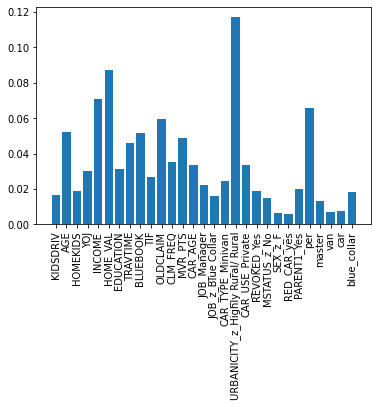

In [37]:
import matplotlib.pyplot as plt 
plt.xticks(rotation='vertical')
plt.bar(rf.feature_names_in_,rf.feature_importances_)

**Commentary :** With random forest, we are able to improve the results for the class 1 even if the global performances (macro precision and recall) are pretty much the same. An interesting perk of RF is that it can provide a degree of importance for each variables used during the prediction. We noticed that the most important features are 'HOME_VAL',  'OLDCLAIM' and 'URBANICITY_z_Highly Rural/ Rural' which seems logical.

### Boosting 

In [38]:
## Gradient Boosting

In [39]:
check_df=pd.concat([df_train_1,df_train_0.sample(n=2500)])
check_df=check_df.sample(frac=1)

In [40]:
x_train,x_test,y_train,y_test=train_test_split(check_df.drop("TARGET_FLAG",axis=1),check_df["TARGET_FLAG"],test_size=0.10)

In [41]:
clf = GradientBoostingClassifier(n_estimators=130, learning_rate=1.,
    max_depth=1, random_state=0).fit(x_train, y_train)
clf.score(x_test, y_test)

0.7381974248927039

In [42]:
y_pred=clf.predict(x_train)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      2265
           1       0.78      0.77      0.78      1922

    accuracy                           0.80      4187
   macro avg       0.80      0.80      0.80      4187
weighted avg       0.80      0.80      0.80      4187



In [43]:
y_pred=clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       235
           1       0.75      0.70      0.73       231

    accuracy                           0.74       466
   macro avg       0.74      0.74      0.74       466
weighted avg       0.74      0.74      0.74       466



In [44]:
check_index_=(clf.feature_importances_>0.08)*1
check_index=clf.feature_names_in_[np.nonzero(check_index_)]
clf.feature_names_in_[np.nonzero(check_index_)]

array(['HOME_VAL', 'OLDCLAIM', 'URBANICITY_z_Highly Rural/ Rural',
       'CAR_USE_Private'], dtype=object)

In [45]:
## AdaBoost

In [46]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=130)
ada.fit(x_train,y_train)
ada.score(x_test,y_test)

0.7339055793991416

In [47]:
ypred=ada.predict(x_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       235
           1       0.75      0.70      0.72       231

    accuracy                           0.73       466
   macro avg       0.73      0.73      0.73       466
weighted avg       0.73      0.73      0.73       466



<BarContainer object of 29 artists>

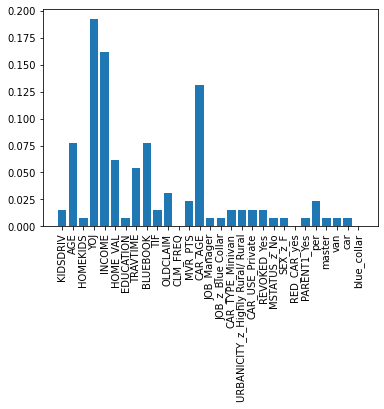

In [48]:
plt.xticks(rotation='vertical')
plt.bar(ada.feature_names_in_,ada.feature_importances_)

In [49]:
check_index_=(ada.feature_importances_>0.08)*1
check_index=ada.feature_names_in_[np.nonzero(check_index_)]
ada.feature_names_in_[np.nonzero(check_index_)]

array(['YOJ', 'INCOME', 'CAR_AGE'], dtype=object)

**Commentary :** The most important variables are more or less consistant across all the tested models. Let us also not that we used for the training of the boosting models the non-standardized data because it works better.  
We chose to keep the GradientBoostingClassifier as final model since it has the best f1-score on the test set. We should have used cross_validation f1-score for the comparison, however we ensure that GradientBoostingClassifier was the best model by running the sampling, training and testing multiple times. 

### Final training and prediction 

In [50]:
final_train=pd.concat([df_train_1,df_train_0.sample(n=2500)])
final_train_x=final_train.drop("TARGET_FLAG",axis=1)
final_train_y=final_train["TARGET_FLAG"]

In [51]:
## Training : We use random forest
#rf=RandomForestClassifier(max_depth=9,n_estimators=100)
#rf.fit(final_train_x,final_train_y)
clf = GradientBoostingClassifier(n_estimators=130, learning_rate=1.,
    max_depth=1, random_state=0).fit(final_train_x, final_train_y)

In [52]:
## Prediction
y_pred=clf.predict(df_test.drop("TARGET_FLAG",axis=1))

In [53]:
## final csv file
df_test["TARGET_FLAG"]=y_pred
df_test["TARGET_FLAG"].to_csv("pred_Descartes_und.csv")

In [54]:
df_test["TARGET_FLAG"].sum()/len(y_pred)

0.38206445586174687